In [ ]:
import tensorflow as tf

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-rtgvcj3b
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-rtgvcj3b
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=a7bed75b4e2d1b617061a4ef0eb25782b79b609e16b8a8bc2691f6ef12e7169e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xd5ehica/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf

# Paths to data folders
data_dir = '/content/drive/MyDrive/train5000'
sketch_dir = os.path.join(data_dir, 'sketches')
images_dir = os.path.join(data_dir, 'images')

# Helper function to extract numeric part from filenames for sorting
def extract_number(filename):
    base_name = filename.split('.')[0]
    number_part = base_name.split('_')[0] if '_' in base_name else base_name
    return int(number_part)

# Load, sort file paths
sketch_files = sorted(os.listdir(sketch_dir), key=extract_number)
images_files = sorted(os.listdir(images_dir), key=extract_number)
sketch_files = [os.path.join(sketch_dir, file) for file in sketch_files]
images_files = [os.path.join(images_dir, file) for file in images_files]

# Training set split
train_size = int(0.9 * len(sketch_files))
train_sketch_files = sketch_files[:train_size]
train_images_files = images_files[:train_size]
test_sketch_files = sketch_files[train_size:]
test_images_files = images_files[train_size:]

# Load and decode images
def load_and_preprocess_image(filepath):
    image_data = tf.io.read_file(filepath)
    try:
        image = tf.image.decode_png(image_data, channels=3)
        image = tf.image.resize(image, [256, 256])  # Resize images
        image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
        return image
    except tf.errors.InvalidArgumentError as e:
        print(f"Error loading image from {filepath}: {e}")
        return None

# Filtering out None values and creating datasets
def filter_none_images(image):
    return image is not None

# Create TensorFlow datasets
train_sketch_dataset = tf.data.Dataset.from_tensor_slices(train_sketch_files)
train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images_files)
train_sketch_dataset = train_sketch_dataset.map(load_and_preprocess_image).filter(filter_none_images)
train_images_dataset = train_images_dataset.map(load_and_preprocess_image).filter(filter_none_images)

# Configure training dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.zip((train_sketch_dataset, train_images_dataset))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(8).prefetch(AUTOTUNE)

# Optionally, repeat the steps above for test_dataset if needed
# Print file paths to verify
for sketch_file, image_file in zip(sketch_files, images_files):
    print(f"Sketch file: {sketch_file}")
    print(f"Image file: {image_file}\n")


Streaming output truncated to the last 5000 lines.
Image file: /content/drive/MyDrive/train5000/images/3334.png

Sketch file: /content/drive/MyDrive/train5000/sketches/3335_sketch.png
Image file: /content/drive/MyDrive/train5000/images/3335.png

Sketch file: /content/drive/MyDrive/train5000/sketches/3336_sketch.png
Image file: /content/drive/MyDrive/train5000/images/3336.png

Sketch file: /content/drive/MyDrive/train5000/sketches/3337_sketch.png
Image file: /content/drive/MyDrive/train5000/images/3337.png

Sketch file: /content/drive/MyDrive/train5000/sketches/3338_sketch.png
Image file: /content/drive/MyDrive/train5000/images/3338.png

Sketch file: /content/drive/MyDrive/train5000/sketches/3339_sketch.png
Image file: /content/drive/MyDrive/train5000/images/3339.png

Sketch file: /content/drive/MyDrive/train5000/sketches/3340_sketch.png
Image file: /content/drive/MyDrive/train5000/images/3340.png

Sketch file: /content/drive/MyDrive/train5000/sketches/3341_sketch.png
Image file: /conte

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:


def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image):
    image = normalize(image)
    return image


In [ ]:
import tensorflow as tf

# Ensure TensorFlow executes operations eagerly to better debug
# This line can slow down the execution, only use it if necessary for debugging
tf.config.run_functions_eagerly(True)

# Define constants for dataset operations
BUFFER_SIZE = 1000  # Adjust as needed based on your dataset size
BATCH_SIZE = 8  # Typical batch sizes are 32, 64, or 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Helper function to load and preprocess images
def load_and_preprocess_image(filepath):
    image_data = tf.io.read_file(filepath)
    try:
        image = tf.image.decode_png(image_data, channels=3)
        image = tf.image.resize(image, [256, 256])  # Resize to uniform size
        image = (image - 127.5) / 127.5  # Normalize to range [-1, 1]
        return image
    except tf.errors.InvalidArgumentError as e:
        print(f"Error loading image from {filepath}: {e}")
        return None

# Filter out None values from the dataset (images that couldn't be loaded)
def filter_none_images(image):
    return image is not None

# Create TensorFlow datasets from file path lists
train_sketch_dataset = tf.data.Dataset.from_tensor_slices(train_sketch_files)
train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images_files)
test_sketch_dataset = tf.data.Dataset.from_tensor_slices(test_sketch_files)
test_images_dataset = tf.data.Dataset.from_tensor_slices(test_images_files)

# Apply preprocessing, shuffling, and batching to datasets
train_sketch_dataset = train_sketch_dataset.map(
    load_and_preprocess_image, num_parallel_calls=AUTOTUNE
).filter(filter_none_images).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_images_dataset = train_images_dataset.map(
    load_and_preprocess_image, num_parallel_calls=AUTOTUNE
).filter(filter_none_images).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_sketch_dataset = test_sketch_dataset.map(
    load_and_preprocess_image, num_parallel_calls=AUTOTUNE
).filter(filter_none_images).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_images_dataset = test_images_dataset.map(
    load_and_preprocess_image, num_parallel_calls=AUTOTUNE
).filter(filter_none_images).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Print the shape of the first data entry in each dataset to confirm setup
#for data in train_sketch_dataset.take(1):
 #   print("Data shape in train_sketch_dataset:", data.shape)

#for data in train_images_dataset.take(1):
 #3   print("Data shape in train_images_dataset:", data.shape)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
#sample_sketch = next(iter(train_sketch_dataset))
#sample_images = next(iter(train_images_dataset))
sample_dataset=next(iter(train_dataset))

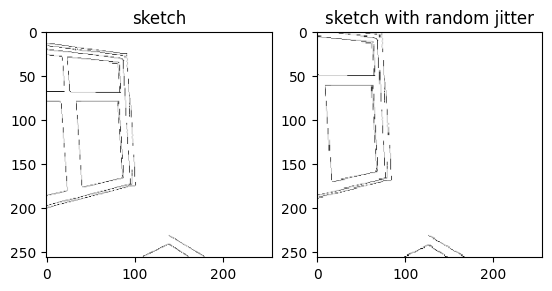

In [ ]:
plt.subplot(121)
plt.title('sketch')
plt.imshow(sample_dataset[0][3] * 0.5 + 0.5)

plt.subplot(122)
plt.title('sketch with random jitter')
plt.imshow(random_jitter(sample_dataset[0][3]) * 0.5 + 0.5)

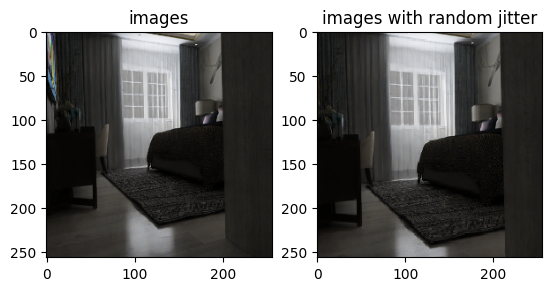

In [ ]:
plt.subplot(121)
plt.title('images')
plt.imshow(sample_dataset[1][0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('images with random jitter')
plt.imshow(random_jitter(sample_dataset[1][0]) * 0.5 + 0.5)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

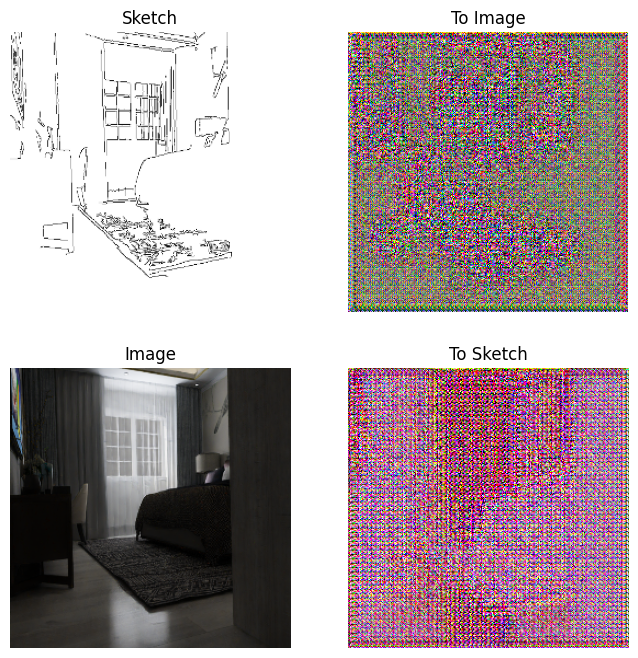

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def resize_images(image):
    # Resize the image to the expected size (256x256)
    # Ensure image has 3 channels, assuming RGB images
    return tf.image.resize(image, [256, 256])

# Assuming sample_dataset[0][0] and sample_dataset[1][0] are tensors with shape [height, width, channels]
# Apply resizing to the input images
sample_sketch_resized = resize_images(sample_dataset[0][0])
sample_images_resized = resize_images(sample_dataset[1][0])

# Add a batch dimension to fit the model's input requirements
sample_sketch_resized = tf.expand_dims(sample_sketch_resized, axis=0)
sample_images_resized = tf.expand_dims(sample_images_resized, axis=0)

# Pass the resized images to the U-Net generator
to_image = generator_g(sample_sketch_resized)
to_sketch = generator_f(sample_images_resized)

# Remove the batch dimension for plotting
sample_sketch_resized = tf.squeeze(sample_sketch_resized)
sample_images_resized = tf.squeeze(sample_images_resized)
to_image = tf.squeeze(to_image)
to_sketch = tf.squeeze(to_sketch)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_sketch_resized, to_image, sample_images_resized, to_sketch]
titles = ['Sketch', 'To Image', 'Image', 'To Sketch']

for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])
    # Normalize and adjust contrast for visualization
    if i % 2 == 0:
        plt.imshow((imgs[i].numpy() * 0.5 + 0.5).clip(0, 1))
    else:
        # Apply higher contrast to generated images
        plt.imshow((imgs[i].numpy() * 0.5 * contrast + 0.5).clip(0, 1))
    plt.axis('off')

plt.show()


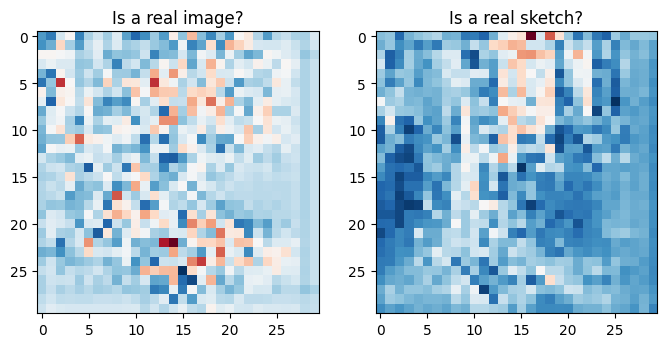

In [ ]:
sample_image = tf.expand_dims(sample_dataset[0][0], axis=0)  # Add batch dimension to the image
sample_sketch = tf.expand_dims(sample_dataset[1][0], axis=0)  # Add batch dimension to the sketch

# Using the discriminators to predict if the samples are real
output_real_image = discriminator_y(sample_image)
output_real_sketch = discriminator_x(sample_sketch)

plt.figure(figsize=(8, 8))

# Displaying the discriminator's prediction for real image
plt.subplot(121)
plt.title('Is a real image?')
plt.imshow(output_real_image[0, ..., -1], cmap='RdBu_r')  # Adjust indices accordingly

# Displaying the discriminator's prediction for real sketch
plt.subplot(122)
plt.title('Is a real sketch?')
plt.imshow(output_real_sketch[0, ..., -1], cmap='RdBu_r')  # Adjust indices accordingly

plt.show()

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/newcheckpoints"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=20)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


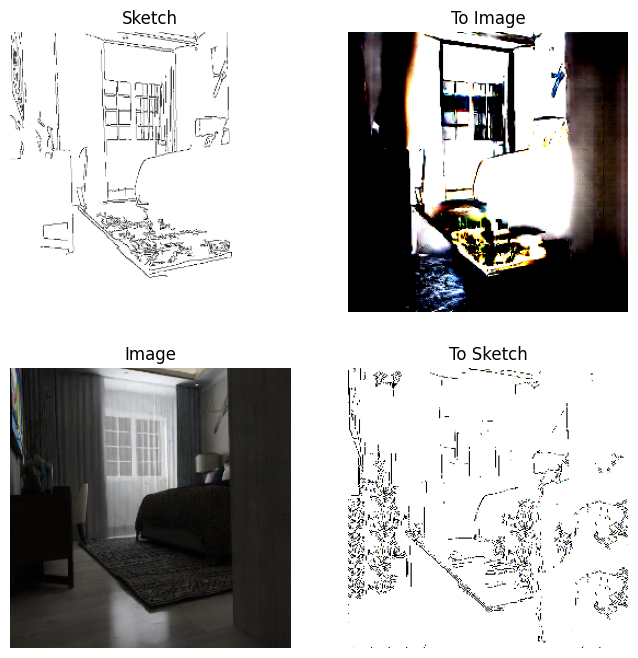

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def resize_images(image):
    # Resize the image to the expected size (256x256)
    # Ensure the image has 3 dimensions, assuming it's a single image
    return tf.image.resize(image, [256, 256])

# First, add a batch dimension if needed and then resize
# Assuming sample_dataset[0][0] is a correctly dimensioned single image tensor
sample_sketch_resized = resize_images(tf.expand_dims(sample_dataset[0][0], axis=0))
sample_images_resized = resize_images(tf.expand_dims(sample_dataset[1][0], axis=0))

# Remove the batch dimension after resizing for processing with the generators
sample_sketch_resized = tf.squeeze(sample_sketch_resized)
sample_images_resized = tf.squeeze(sample_images_resized)

# Pass the resized images to the U-Net generator
to_image = generator_g(tf.expand_dims(sample_sketch_resized, axis=0))
to_sketch = generator_f(tf.expand_dims(sample_images_resized, axis=0))

# Remove the batch dimension for displaying
to_image = tf.squeeze(to_image)
to_sketch = tf.squeeze(to_sketch)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_dataset[0][0], to_image, sample_dataset[1][0], to_sketch]
titles = ['Sketch', 'To Image', 'Image', 'To Sketch']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(titles[i])
    if i % 2 == 0:
        # Normal visualization for input images
        plt.imshow(imgs[i] * 0.5 + 0.5)
    else:
        # Enhanced contrast for generated images
        plt.imshow(imgs[i] * 0.5 * contrast + 0.5)
    plt.axis('off')

plt.show()


ValueError: Exception encountered when calling layer 'sequential_33' (type Sequential).

Input 0 of layer "conv2d_21" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (256, 256, 3)

Call arguments received by layer 'sequential_33' (type Sequential):
  • inputs=tf.Tensor(shape=(256, 256, 3), dtype=float32)
  • training=None
  • mask=None

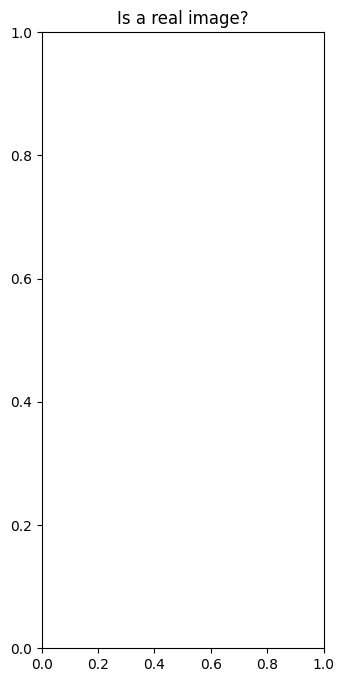

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real image?')
plt.imshow(discriminator_y(sample_dataset[0][0])[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real sketch?')
plt.imshow(discriminator_x(sample_dataset[1][0])[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
EPOCHS = 150

In [ ]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, ground_truth, title):
    prediction = model(test_input)
    plt.figure(figsize=(18, 6))

    display_list = [test_input[0], ground_truth[0], prediction[0]]
    titles = ['Input Image', 'Ground Truth Image', title]  # Use passed title for the predicted image

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)  # Assuming normalization to [0, 1]
        plt.axis('off')
    plt.show()


In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    print(f'generator g (image): {float(gen_g_loss):.4f}')
    print(f'generator f (sketch): {float(gen_f_loss):.4f}')
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    print(f'total generator loss: {float(total_cycle_loss):.4f}')
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    print(f'total generator g (image): {float(total_gen_g_loss):.4f}')
    print(f'total generator f (sketch): {float(total_gen_f_loss):.4f}')
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    print(f'discriminator x loss: {float(disc_x_loss):.4f}')
    print(f'discriminator y loss: {float(disc_y_loss):.4f}')
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

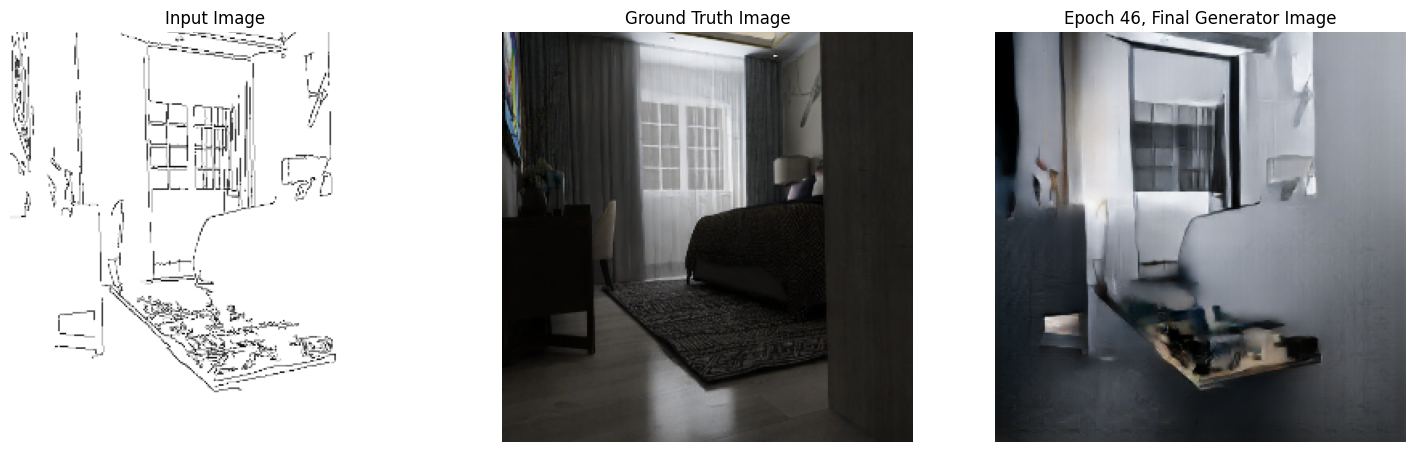

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import time

def train():
    for epoch in range(EPOCHS):
        start = time.time()
        n = 0
        for image_x, image_y in train_dataset:
            try:
                train_step(image_x, image_y)
                if n % 100 == 0:
                    print('.', end='')
                    # Ensure images are properly batched inside the loop
                    batched_sketch = tf.expand_dims(sample_sketch_resized, axis=0)
                    batched_images = tf.expand_dims(sample_images_resized, axis=0)
                    title = f"Epoch {epoch+1}, Step {n}, Generator Image"
                    generate_images(generator_g, batched_sketch, batched_images, title)
                n += 1
            except tf.errors.ResourceExhaustedError:
                print("Memory capacity exceeded during training step")
                break

        # Clear output before generating final images for the epoch
        clear_output(wait=True)
        # Update batched images before final generation
        batched_sketch = tf.expand_dims(sample_sketch_resized, axis=0)
        batched_images = tf.expand_dims(sample_images_resized, axis=0)
        title = f"Epoch {epoch+1}, Final Generator Image"
        generate_images(generator_g, batched_sketch, batched_images, title)

        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))

train()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import time
from IPython.display import clear_output


In [ ]:
# Initialize InceptionV3 without the top classification layer and with global average pooling.
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


In [ ]:
def calculate_fid(model, real_images, generated_images):
    # Resize and preprocess images
    real_images = preprocess_input(tf.image.resize(real_images, (299, 299)))
    generated_images = preprocess_input(tf.image.resize(generated_images, (299, 299)))

    # Use InceptionV3 to extract features
    act1 = model.predict(real_images)
    act2 = model.predict(generated_images)

    # Calculate mean and covariance
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # Calculate the sum of squared differences and trace of covariance matrices
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


generator g (image): 1.7338
generator f (sketch): 7.0317
total generator loss: 1.7847
total generator g (image): 3.7301
total generator f (sketch): 8.9928
discriminator x loss: 0.0220
discriminator y loss: 0.5301
.

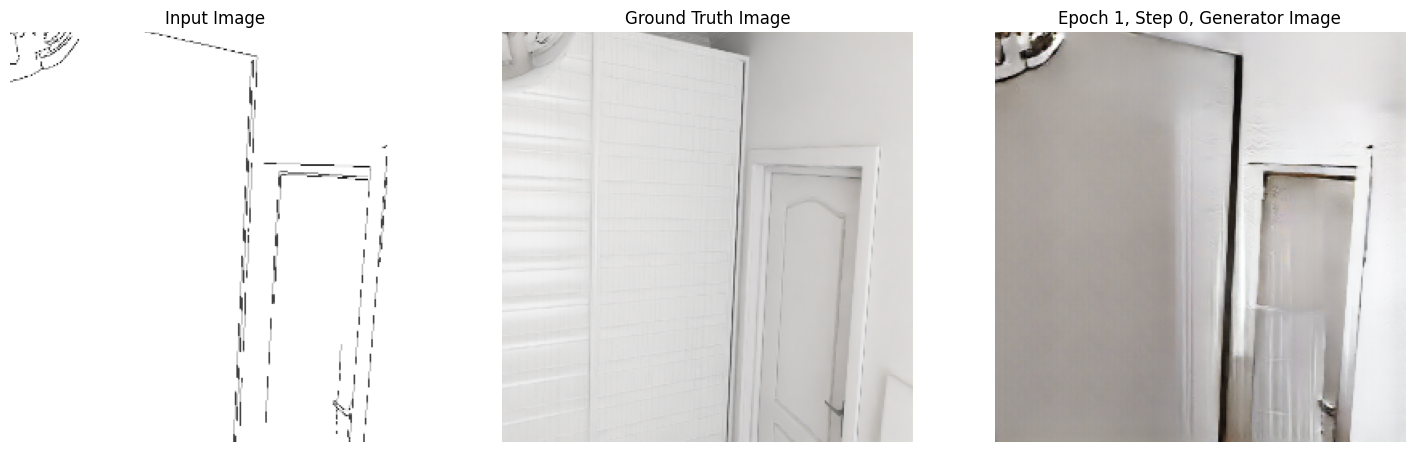

1/1 [==============================] - 1s 1s/step

FID Score at step 0: 2.373737829364982e+78
generator g (image): 1.2236
generator f (sketch): 6.4517
total generator loss: 1.9328
total generator g (image): 3.3294
total generator f (sketch): 8.5834
discriminator x loss: 0.1046
discriminator y loss: 0.5849
generator g (image): 1.1196
generator f (sketch): 4.7272
total generator loss: 2.3860
total generator g (image): 3.7443
total generator f (sketch): 7.4279
discriminator x loss: 0.0325
discriminator y loss: 0.5286
generator g (image): 1.5889
generator f (sketch): 3.3912
total generator loss: 1.9188
total generator g (image): 3.7060
total generator f (sketch): 5.5373
discriminator x loss: 0.0692
discriminator y loss: 0.5199
generator g (image): 0.9996
generator f (sketch): 4.8810
total generator loss: 2.4292
total generator g (image): 3.6294
total generator f (sketch): 7.6361
discriminator x loss: 0.1343
discriminator y loss: 0.5743
generator g (image): 1.1985
generator f (sketch): 3.05

KeyboardInterrupt: 

In [ ]:
def train():
    for epoch in range(EPOCHS):
        start = time.time()
        n = 0
        for image_x, image_y in train_dataset:
            try:
                train_step(image_x, image_y)
                if n % 100 == 0:
                    print('.', end='')
                    # Generate images for validation
                    batched_sketch = tf.expand_dims(sample_sketch_resized, axis=0)
                    batched_images = tf.expand_dims(sample_images_resized, axis=0)
                    title = f"Epoch {epoch+1}, Step {n}, Generator Image"
                    generate_images(generator_g, batched_sketch, batched_images, title)

                    # Calculate FID every 1000 steps
                    if n % 1000 == 0:
                        fid = calculate_fid(inception_model, image_y, generator_g(batched_sketch, training=False))
                        print(f"\nFID Score at step {n}: {fid}")

                n += 1
            except tf.errors.ResourceExhaustedError:
                print("Memory capacity exceeded during training step")
                break

        clear_output(wait=True)
        # Generate final images for the epoch
        generate_images(generator_g, batched_sketch, batched_images, f"Epoch {epoch+1}, Final Generator Image")

        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))
train()
# Assuming the rest of your setup like ckpt_manager, generator_g, train_dataset are defined elsewhere.


In [ ]:
def preprocess_dataset(dataset):
    def load_and_preprocess(image_path):
        # Make sure the input is a string tensor (file path) and not a float32 tensor
        if image_path.dtype != tf.string:
            raise ValueError("Expected input to be of type string, but received type: {}".format(image_path.dtype))

        # Read the image file
        image = tf.io.read_file(image_path)

        # Decode the image file into a tensor
        image = tf.image.decode_jpeg(image, channels=3)

        # Convert the image to float32 and scale to [0, 1]
        image = tf.cast(image, tf.float32) / 255.0

        return image

    # Apply the conversion function to the dataset
    return dataset.map(load_and_preprocess)


# Preprocess the test datasets
test_sketch_dataset = preprocess_dataset(test_sketch_dataset)
test_images_dataset = preprocess_dataset(test_images_dataset)
# Run the trained model on the test dataset
for inp in test_sketch_dataset.take(1):
    print("Data type:", inp.dtype)
    print("Data:", inp)

for inp in test_images_dataset.take(1):
    print(inp.dtype)  # Should print the data type, e.g., tf.float32